In [1]:
import os
print(os.listdir())

['.ipynb_checkpoints', 'ed-vaalit-19.ipynb', 'evaa.csv', 'evaa2.csv', 'evaa3.csv', 'Sources.txt', 'Untitled.ipynb']


Import data

In [70]:
import pandas as pd
# custom encoding, custom delimiter, remove header (first line).
df = pd.read_csv("evaa.csv",encoding = "ISO-8859-1",delimiter=";",skiprows=1)
colnams=list(df.columns)
#shorten column names
for idx, nam in enumerate(colnams): #names, with indices
    colnams[idx] = nam.split(' ', 1)[0] #first word
df.columns = colnams

Transform data

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1)),
    ('std_scaler', StandardScaler())
])

num_attribs = colnams[2:]
#cat_attribs = ['ocean_proximity',]
full_pipeline = ColumnTransformer([
        ("number", num_pipeline, num_attribs),
#        ("category", cat_pipeline, cat_attribs),
    ])
x = full_pipeline.fit_transform(df)

Principal components analysis

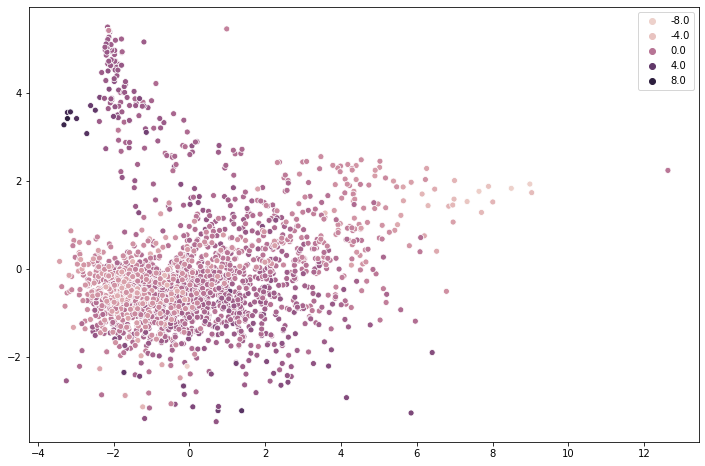

In [72]:
from sklearn import decomposition
import seaborn as sns
pca = decomposition.PCA(n_components=3)
pca.fit(x)
X = pca.transform(x)
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.scatterplot(X[:,0],X[:,1],hue = X[:,2])

Find the location of that rightmost place for fun

In [73]:
interesting_filter = X[:,0]>=10
interesting_index = [i for i, x in enumerate(interesting_filter) if x][0]
df.iloc[interesting_index]['Äänestysalue']

'049 059  Otaniemi'

Look at the components

In [74]:
dkom = {'kom1':pca.components_[0]*100,'kom2':pca.components_[1]*100,'kom3':pca.components_[2]*100}
dfkomponentit = pd.DataFrame(data=dkom, index = colnams[2:])
print(pca.explained_variance_ratio_)
dfkomponentit

[0.20801475 0.11928554 0.07531665]


,kom1,kom2,kom3
SDP,11.228445,-32.132438,33.749684
PS,-10.425988,-52.782823,-5.330209
KOK,27.182217,-6.651189,6.898111
KESK,-30.725192,-24.451095,-33.706688
VIHR,42.802561,2.765089,-14.770832
VAS,13.044769,-20.305755,-44.373649
RKP,-5.199307,45.258897,28.333294
KD,-9.920571,-1.842828,36.280954
SIN,0.968965,-16.542683,25.149419
Piraattip.,41.860879,1.627414,-11.494975


So the components are something like liberalism, swedishness, and traditionalism.

Clustering

C:\Users\Omistaja\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


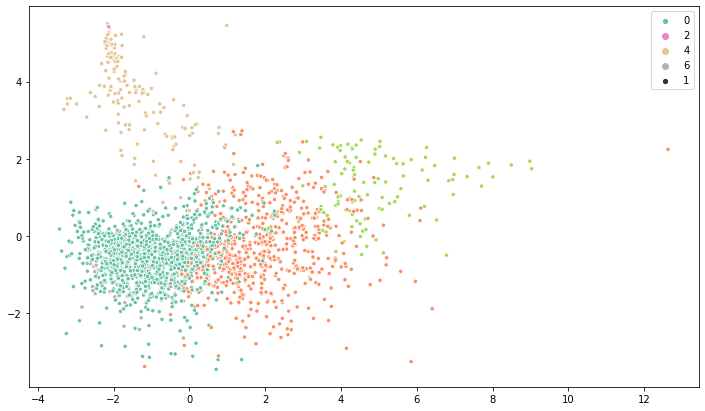

In [75]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(
    n_clusters=6,
    assign_labels="discretize",
    random_state=0,
    affinity = 'nearest_neighbors').fit(x)
fig = plt.gcf()
fig.set_size_inches(12, 7)
sns.scatterplot(X[:,0],X[:,1],hue = clustering.labels_.tolist(),size=1, palette="Set2")

In [8]:
# You might wonder about the category with seemingly a single datapoint.
# That is actually all the voting places at Ahvenanmaa.
# This can be seen after the next code cell with: dflabel[dflabel['label']==2]

Specializing in municipalities

In [76]:
d = {'Äänestysalue': df.Äänestysalue, 'label': clustering.labels_.tolist()}
dflabel = pd.DataFrame(data=d)
dflabel = dflabel.drop(0)
dfkunval = pd.read_csv("evaa_kunnat.csv",encoding = "ISO-8859-1",delimiter=";",skiprows=1)[['Äänestysalue']]
kunvals = list(dfkunval.Äänestysalue)[1:]

kunnat = [k for k in kunvals if 'vaalipiiri' not in k]
dfkunnat = pd.DataFrame(kunnat,columns=['Äänestysalue'])
dfkl = pd.merge(dfkunnat, dflabel, on='Äänestysalue')

#remove numbers from municipal names
for idx, nam in enumerate(kunnat): #nams, with indices
    kunnat[idx] = nam.split(' ', 1)[1] #first word
dfkl.Äänestysalue = kunnat
dfkl = dfkl.rename(columns={"Äänestysalue": "kunta"})

Making a map

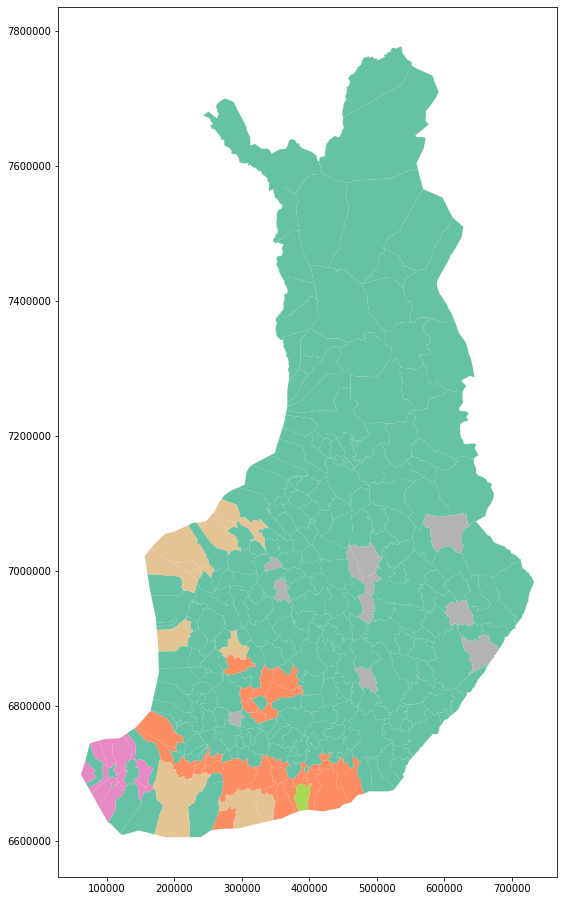

In [77]:
import geopandas as gpd
sfp='Kuntajako.mif'
map_df = gpd.read_file(sfp)[['namefin', 'geometry']]
map_df = map_df.rename(columns={"namefin": "kunta"})
final_df = pd.merge(map_df, dfkl, how='left', on='kunta')
final_df['label'].fillna(value=0, inplace=True)
#I color the municipalities with unknown category with the most prevalent color
#(these are a result of naming mismatches between 'Kuntajako' and 'evaa_kunnat')

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette('Set2').as_hex())
final_df.plot(column = 'label',figsize=(10, 16), cmap=my_cmap)